In [1]:
import torch
import math
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():    
    device = torch.device('cuda:0')    
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [36]:
class DNNModel(torch.nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,        
        ):
        super(DNNModel, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [37]:
class PINN():
    def __init__(self):
        
        self.model = DNNModel(
            input_size=2,
            hidden_size=50,
            output_size=5,
            depth=8,
            act=torch.nn.Tanh,            
            ).to(device)


In [57]:
pinn_tm=torch.load('tm_lhs_8l_0.08m_0.1-0.00015.t7')

model = pinn_tm.model
model.eval()

DNNModel(
  (layers): Sequential(
    (input): Linear(in_features=2, out_features=50, bias=True)
    (input_activation): Tanh()
    (hidden_0): Linear(in_features=50, out_features=50, bias=True)
    (activation_0): Tanh()
    (hidden_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): Tanh()
    (hidden_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): Tanh()
    (hidden_3): Linear(in_features=50, out_features=50, bias=True)
    (activation_3): Tanh()
    (hidden_4): Linear(in_features=50, out_features=50, bias=True)
    (activation_4): Tanh()
    (hidden_5): Linear(in_features=50, out_features=50, bias=True)
    (activation_5): Tanh()
    (hidden_6): Linear(in_features=50, out_features=50, bias=True)
    (activation_6): Tanh()
    (hidden_7): Linear(in_features=50, out_features=50, bias=True)
    (activation_7): Tanh()
    (output): Linear(in_features=50, out_features=5, bias=True)
  )
)

In [58]:
x = torch.arange(1, 2 + 0.005 , 0.005)
y = torch.arange(1, 2 +0.01, 0.01)

outlet= torch.stack(torch.meshgrid(x, y[-1])).reshape(2, -1).T
outlet = outlet.to(device)
outlet.requires_grad = True

y_out = model(outlet)
dpsi_dX = torch.autograd.grad(inputs=outlet, outputs=y_out[:,0], grad_outputs=torch.ones_like(y_out[:,0]), retain_graph=True, create_graph=True)[0]
dpsi_dX[:, 0] = -1*dpsi_dX[:, 0]    

out=torch.cat([outlet, dpsi_dX ,y_out], 1)
out=out.detach().cpu().numpy()
np.savetxt('TM_outlet.dat', out)

x = torch.arange(0, 3+0.05 ,0.05 )
y = torch.arange(0, 1+0.05 , 0.05)

x1 = torch.arange(1, 2+0.05 ,0.05 )
y1 = torch.arange(1, 2+0.05 , 0.05)

tm1 = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
tm2 = torch.stack(torch.meshgrid(x1, y1)).reshape(2, -1).T

tm = torch.cat([tm1, tm2])

channel = tm.to(device)
channel.requires_grad = True

y_pred = model(channel)
dpsi_dX = torch.autograd.grad(inputs=channel, outputs=y_pred[:,0], grad_outputs=torch.ones_like(y_pred[:,0]), retain_graph=True, create_graph=True)[0]
dpsi_dX[:, 0] = -1*dpsi_dX[:, 0]   

fld=torch.cat([channel, dpsi_dX ,y_pred], 1)
fld=fld.detach().cpu().numpy()
np.savetxt('TM.dat', fld)

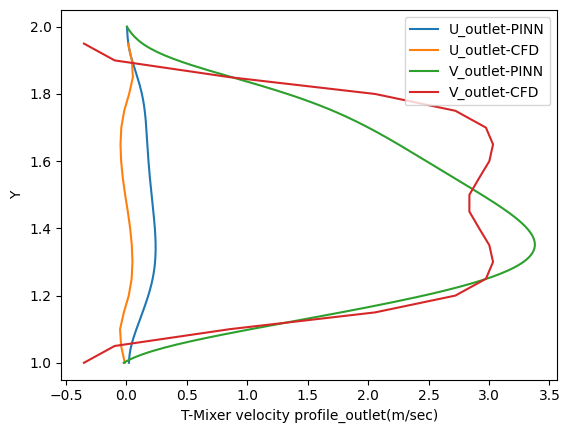

In [60]:
U=np.loadtxt('U-CFD.dat')

plt.plot(np.array(out[:,3]).reshape(201,-1),out[:,0].reshape(201,-1), label="U_outlet-PINN")
plt.plot(U[:,1].reshape(20,-1),U[:,0].reshape(20,-1),label="U_outlet-CFD")
plt.plot(np.array(out[:,2]).reshape(201,-1),out[:,0].reshape(201,-1), label="V_outlet-PINN")
plt.plot(U[:,2].reshape(20,-1),U[:,0].reshape(20,-1), label="V_outlet-CFD")
plt.legend(loc=1)
plt.xlabel("T-Mixer velocity profile_outlet(m/sec)")
plt.ylabel("Y")
plt.show()

In [55]:
x = torch.arange(1, 2, 0.05)
y = torch.arange(1, 2, 0.05)

outlet= torch.stack(torch.meshgrid(x, y[-1])).reshape(2, -1).T
outlet = outlet.to(device)
outlet.requires_grad = True

y_out = model(outlet)
dpsi_dX = torch.autograd.grad(inputs=outlet, outputs=y_out[:,0], grad_outputs=torch.ones_like(y_out[:,0]), retain_graph=True, create_graph=True)[0]
dpsi_dX[:, 0] = -1*dpsi_dX[:, 0]    

out=torch.cat([outlet, dpsi_dX ,y_out], 1)
out=out.detach().cpu().numpy()

umse = np.square(np.subtract(U[:,1],out[:,3])).mean() 
vmse = np.square(np.subtract(U[:,2],out[:,2])).mean()

urms = math.sqrt(umse)
vrms = math.sqrt(vmse)

print("U_rms=", urms,"V_rms=", vrms)

U_rms= 0.1437601003570242 V_rms= 0.4983537575143935
